##Exploring Quantum Kernel Alignment Runtime for optimizing Quantum Neural Network

In [ ]:
!pip install kaggle
!pip install qiskit
!pip install torch

## Importing required Modules

In [ ]:
#Importing Supporting Python  Modules
import numpy as np
import os
cwd = os.getcwd()
from PIL import Image
import time
import copy
import random
import cv2
import re
import shutil
from itertools import combinations
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

#Importing Pytorch Specific Modules
import torch
import kaggle
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.autograd import Function
import torch.nn.functional as F


#Importing Qiskit Specific Modules
import qiskit
from qiskit.visualization import *
from qiskit.circuit.random import random_circuit
from qiskit import transpile, assemble
from qiskit.visualization import *

## Load the Cracks Dataset and Visualize it
* Link to the cracks data set:  https://data.mendeley.com/datasets/5y9wdsg2zt/2


In [ ]:
from google.colab import files
files.upload() ## Upload your kaggle.json credentials file

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!pip install torch 

In [ ]:
!kaggle datasets download -d arunrk7/surface-crack-detection

 93% 216M/233M [00:02<00:00, 131MB/s]
100% 233M/233M [00:02<00:00, 112MB/s]


In [ ]:
!unzip surface-crack-detection.zip

In [ ]:
crack_images = os.listdir('Positive/')
print("Number of Crack Images: ", len(crack_images))

In [ ]:
no_crack_images = os.listdir('Negative/')
print("Number of No Crack Images: ", len(no_crack_images))

*****************Random Images with Cracks**************************


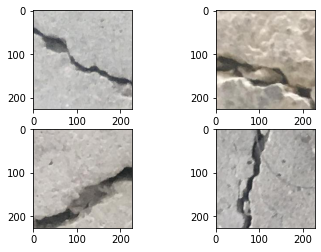

In [ ]:
## Visualize Random images with cracks
random_indices = np.random.randint(0, len(crack_images), size=4)
print("*****************Random Images with Cracks**************************")
random_images = np.array(crack_images)[random_indices.astype(int)]

f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(mpimg.imread(os.path.join(cwd, 'Positive', random_images[0])))
axarr[0,1].imshow(mpimg.imread(os.path.join(cwd, 'Positive', random_images[1])))
axarr[1,0].imshow(mpimg.imread(os.path.join(cwd, 'Positive', random_images[2])))
axarr[1,1].imshow(mpimg.imread(os.path.join(cwd, 'Positive', random_images[3])))

*****************Random Images without Cracks**************************


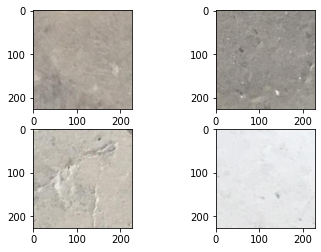

In [ ]:
## Visualize Random images with no cracks
random_indices = np.random.randint(0, len(no_crack_images), size=4)
print("*****************Random Images without Cracks**************************")
random_images = np.array(no_crack_images)[random_indices.astype(int)]

f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(mpimg.imread(os.path.join(cwd, 'Negative', random_images[0])))
axarr[0,1].imshow(mpimg.imread(os.path.join(cwd, 'Negative', random_images[1])))
axarr[1,0].imshow(mpimg.imread(os.path.join(cwd, 'Negative', random_images[2])))
axarr[1,1].imshow(mpimg.imread(os.path.join(cwd, 'Negative', random_images[3])))

## Create Train and Val Data sets

### Create training folder

In [ ]:
!rm -rf train
base_dir = cwd
files = os.listdir(base_dir)

def create_training_data(folder_name):
    train_dir = f"{base_dir}/train/{folder_name}"
    for f in files:
        search_object = re.search(folder_name, f)
        if search_object:
            shutil.move(f'{base_dir}/{folder_name}', train_dir)

'rm' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
create_training_data('Positive')
create_training_data('Negative')
!rm -rf val

'rm' is not recognized as an internal or external command,
operable program or batch file.


### Move images randomly from training to val folders

In [ ]:
os.makedirs('val/Positive')
os.makedirs('val/Negative')

In [ ]:
positive_train = base_dir + "/train/Positive/"
positive_val = base_dir + "/val/Positive/"
negative_train = base_dir + "/train/Negative/"
negative_val = base_dir + "/val/Negative/"

positive_files = os.listdir(positive_train)
negative_files = os.listdir(negative_train)

In [ ]:
print(len(positive_files), len(negative_files))

15974 15892


## QKA

##Loading IBM Quantum account and get the quantum backend

In [ ]:
# !pip install qiskit
import sys
#sys.path.insert(0, 'qiskit-runtime-main/qiskit-runtime-main/qiskit_runtime') # Add qiskit_runtime directory to the path
from qiskit import *
from qiskit import IBMQ
IBMQ.save_account('YOUR IBM QUANTUM KEY')
IBMQ.load_account() # Load account from disk
IBMQ.providers()    # List all available providers
provider = IBMQ.load_account()
print(f"Do I have access to Qiskit Runtime? {provider.has_service('runtime')}")

configrc.store_credentials:WARNING:2021-08-30 16:29:48,026: Credentials already present. Set overwrite=True to overwrite.
ibmqfactory.load_account:WARNING:2021-08-30 16:29:54,525: Credentials are already in use. The existing account in the session will be replaced.


Do I have access to Qiskit Runtime? True


In [ ]:
provider = IBMQ.get_provider(hub='ibm-q', group='open',project='main') # Change this to your provider.
backend = provider.get_backend('ibmq_qasm_simulator')

##Invoke the Quantum Kernel Alignment program

In [ ]:
import os
def ListofFiles(Dir):
    Files = []
    for root, dir_name, file_name in os.walk(Dir): 
#root store address till directory, dir_name stores directory name # file_name stores file name
        for name in file_name:
            fullName = os.path.join(root, name)
            Files.append(fullName)
    return Files

In [ ]:
FileList = ListofFiles('train/Positive') #Same do for Negative

In [ ]:
from PIL import Image,ImageOps
pixels=[]
for file in FileList[:100]:
    Im = Image.open(file)
    Im1= ImageOps.grayscale(Im)
    Im1 = Im1.resize((6,6), resample=Image.LANCZOS) 
    pixels.append(list(Im1.getdata()))

In [ ]:
import numpy as np
from numpy import savetxt
pixels_arr=np.asarray(pixels)
pixels_arr = pixels_arr.reshape(pixels_arr.shape[0],-1)
print(pixels_arr.shape)
savetxt('numbers_positive_downsampled.csv', pixels_arr, delimiter=',')

(100, 36)


In [ ]:
from csv import writer
from csv import reader
default_text = float(1)

with open('numbers_positive_downsampled.csv', 'r') as read_obj, \
        open('numbers_positive_mark_downsampled_marked.csv', 'w', newline='') as write_obj:
    csv_reader = reader(read_obj)
    csv_writer = writer(write_obj)
    
    for row in csv_reader:
       
        row.append(default_text)
        csv_writer.writerow(row)

In [ ]:
import pandas as pd

df_list = []
for file_name in ['numbers_positive_mark_downsampled_marked.csv', 'numbers_negative_mark_downsampled_marked.csv']:
    df = pd.read_csv(file_name,header=None)
    df_list.append(df)

df_concat = pd.concat(df_list)
print(df_concat)

       0      1      2      3      4      5      6      7      8      9   ...  \
0   139.0  121.0  115.0  138.0  135.0  137.0  138.0  132.0  114.0  137.0  ...   
1   153.0  153.0  152.0  160.0  148.0  155.0  154.0  156.0  153.0  156.0  ...   
2   147.0  148.0  147.0  149.0  126.0  141.0  146.0  146.0  148.0  142.0  ...   
3   160.0  162.0  161.0  146.0  137.0  152.0  160.0  161.0  161.0  147.0  ...   
4   153.0  151.0  155.0  140.0  138.0  153.0  151.0  151.0  153.0  138.0  ...   
5   160.0  155.0  142.0  145.0  120.0  132.0  153.0  150.0  143.0  146.0  ...   
6   156.0  128.0  116.0  153.0  151.0  151.0  155.0  143.0  109.0  152.0  ...   
7   148.0  142.0  136.0  148.0  148.0  151.0  147.0  143.0  125.0  146.0  ...   
8   154.0  130.0  142.0  149.0  147.0  146.0  157.0  134.0  136.0  150.0  ...   
9   150.0  135.0  132.0  149.0  147.0  150.0  149.0  144.0  136.0  151.0  ...   
10  155.0  153.0  158.0  152.0  153.0  165.0  157.0  153.0  157.0  153.0  ...   
11  152.0  158.0  156.0  148

In [ ]:
df_concat = df_concat.sort_index(axis=0, level=None, ascending=True, inplace=False, kind='mergesort', na_position='last', sort_remaining=True, ignore_index=True, key=None)
print(df_concat)

        0      1      2      3      4      5      6      7      8      9   \
0    139.0  121.0  115.0  138.0  135.0  137.0  138.0  132.0  114.0  137.0   
1    163.0  164.0  164.0  162.0  162.0  164.0  158.0  161.0  159.0  165.0   
2    153.0  153.0  152.0  160.0  148.0  155.0  154.0  156.0  153.0  156.0   
3    157.0  163.0  162.0  154.0  154.0  150.0  152.0  159.0  162.0  165.0   
4    147.0  148.0  147.0  149.0  126.0  141.0  146.0  146.0  148.0  142.0   
5    173.0  203.0  185.0  168.0  182.0  169.0  158.0  181.0  181.0  183.0   
6    160.0  162.0  161.0  146.0  137.0  152.0  160.0  161.0  161.0  147.0   
7    203.0  200.0  199.0  197.0  198.0  202.0  202.0  200.0  199.0  199.0   
8    153.0  151.0  155.0  140.0  138.0  153.0  151.0  151.0  153.0  138.0   
9    199.0  200.0  199.0  197.0  197.0  198.0  200.0  200.0  192.0  192.0   
10   160.0  155.0  142.0  145.0  120.0  132.0  153.0  150.0  143.0  146.0   
11   186.0  186.0  186.0  185.0  183.0  178.0  187.0  185.0  185.0  185.0   

In [ ]:
df_concat.to_csv('numbers_merged_downsampled.csv', index=False)

In [ ]:
pd.set_option("display.max_rows", None)


##Loading Dataset

In [ ]:
import pandas as pd

df = pd.read_csv('numbers_merged_downsampled.csv',sep=',', header=None) # alterative problem: dataset_graph10.csv
data = df.values
print(data)

[[  0.   1.   2. ...  34.  35.  36.]
 [139. 121. 115. ... 132. 140.   1.]
 [163. 164. 164. ... 168. 167.  -1.]
 ...
 [221. 214. 212. ... 219. 214.  -1.]
 [147. 140. 140. ... 139. 141.   1.]
 [213. 204. 197. ... 209. 210.  -1.]]


In [ ]:
import numpy as np

# choose number of training and test samples per class:
num_train = 7
num_test =7

# extract training and test sets and sort them by class label
train = data[:2*num_train, :]
test = data[2*num_train:2*(num_train+num_test), :]

ind=np.argsort(train[:,-1])
x_train = train[ind][:,:-1]
y_train = train[ind][:,-1]

ind=np.argsort(test[:,-1])
x_test = test[ind][:,:-1]
y_test = test[ind][:,-1]

In [ ]:
print(y_test)

[-1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.]


In [ ]:
runtime_backends = provider.backends(input_allowed='runtime')
print(runtime_backends)

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>]


##Configure the QKA algorithm

In [ ]:
from qka import FeatureMap
 
d =  36              # feature dimension is twice the qubit number

em = [[0,1],[1,2],[2,3],[3,4],[4,5],[5,6],[6,7],[7,8],[8,9],[9,10],[10,11],[11,12],[12,13],[13,14],[14,15],[15,16],[16,17]]
#m = [[0,1],[2,3],[4,5],[6,7],[8,9],[1,2],[3,4],[5,6],[7,8]]
fm = FeatureMap(feature_dimension=d, entangler_map=em)          # define the feature map
initial_point = [-300] #set the initial parameter for the feature map



In [ ]:
print(x_train.shape)

(14, 36)


In [ ]:
from qiskit.tools.visualization import circuit_drawer
circuit_drawer(fm.construct_circuit(x=x_train[0], parameters=initial_point),
               output='text', fold=200)

┌─────────┐   ┌──────────┐┌──────────┐                                                                                                                                                »
 q_0: ┤ Ry(300) ├─■─┤ Rz(-328) ├┤ Rx(-326) ├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────»
      ├─────────┤ │ └──────────┘├──────────┤┌──────────┐                                                                                                                                    »
 q_1: ┤ Ry(300) ├─■──────■──────┤ Rz(-324) ├┤ Rx(-328) ├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────»
      ├─────────┤        │      └──────────┘├──────────┤┌──────────┐                                                                                                                        »
 q_2: ┤ Ry(300) ├────────■───────────■──────┤ Rz(-328) ├┤ Rx(-324) ├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────»
      ├─────────┤                    │      └──────────┘├──────────┤┌──────────┐                                                                                                            »
 q_3: ┤ Ry(300) ├────────────────────■───────────■──────┤ Rz(-322) ├┤ Rx(-316) ├────────────────────────────────────────────────────────────────────────────────────────────────────────────»
      ├─────────┤                                │      └──────────┘├──────────┤┌──────────┐                                                                                                »
 q_4: ┤ Ry(300) ├────────────────────────────────■───────────■──────┤ Rz(-330) ├┤ Rx(-318) ├────────────────────────────────────────────────────────────────────────────────────────────────»
      ├─────────┤                                            │      └──────────┘├──────────┤┌──────────┐                                                                                    »
 q_5: ┤ Ry(300) ├────────────────────────────────────────────■───────────■──────┤ Rz(-336) ├┤ Rx(-336) ├────────────────────────────────────────────────────────────────────────────────────»
      ├─────────┤                                                        │      └──────────┘├──────────┤┌──────────┐                                                                        »
 q_6: ┤ Ry(300) ├────────────────────────────────────────────────────────■───────────■──────┤ Rz(-328) ├┤ Rx(-322) ├────────────────────────────────────────────────────────────────────────»
      ├─────────┤                                                                    │      └──────────┘├──────────┤┌──────────┐                                                            »
 q_7: ┤ Ry(300) ├────────────────────────────────────────────────────────────────────■───────────■──────┤ Rz(-320) ├┤ Rx(-318) ├────────────────────────────────────────────────────────────»
      ├─────────┤                                                                                │      └──────────┘├──────────┤┌──────────┐                                                »
 q_8: ┤ Ry(300) ├────────────────────────────────────────────────────────────────────────────────■───────────■──────┤ Rz(-336) ├┤ Rx(-332) ├────────────────────────────────────────────────»
      ├─────────┤                                                                                            │      └──────────┘├──────────┤┌──────────┐                                    »
 q_9: ┤ Ry(300) ├────────────────────────────────────────────────────────────────────────────────────────────■───────────■──────┤ Rz(-324) ├┤ Rx(-322) ├────────────────────────────────────»
      ├─────────┤                                                                                                        │      └──────────┘├──────────┤┌──────────┐                        »
q_10: ┤ Ry(300) 

In [ ]:
C = 1                                                       # SVM soft-margin penalty
maxiters = 5                                                 # number of SPSA iterations

In [ ]:
initial_layout = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18] # Arbitary layout for 18 qubits       
#initial_layout = [9, 8, 11, 14, 16, 19, 22, 25, 24, 23]       # see figure above for the 10-qubit graph

In [ ]:
print(provider.runtime.program('quantum-kernel-alignment'))

quantum-kernel-alignment:
  Name: quantum-kernel-alignment
  Description: Quantum kernel alignment algorithm that learns, on a given dataset, a quantum kernel maximizing the SVM classification margin.
  Version: 1
  Creation date: 2021-05-06T14:56:53.000000
  Max execution time: 28800
  Input parameters:
    - feature_map:
      Description: An instance of FeatureMap in dictionary format used to map classical data into a quantum state space.
      Type: dict
      Required: True
    - data:
      Description: NxD array of training data, where N is the number of samples and D is the feature dimension.
      Type: numpy.ndarray
      Required: True
    - labels:
      Description: Nx1 array of +/-1 labels of the N training samples.
      Type: numpy.ndarray
      Required: True
    - initial_kernel_parameters:
      Description: Initial parameters of the quantum kernel. If not specified, an array of randomly generated numbers is used.
      Type: numpy.ndarray
      Required: False
    -

In [ ]:
def interim_result_callback(job_id, interim_result):
    print(f"interim result: {interim_result}\n")

In [ ]:
print(x_train)

[[163. 164. 164. 162. 162. 164. 158. 161. 159. 165. 168. 168. 161. 164.
  159. 160. 166. 168. 161. 162. 161. 162. 162. 165. 164. 162. 161. 166.
  168. 170. 159. 166. 167. 167. 168. 167.]
 [157. 163. 162. 154. 154. 150. 152. 159. 162. 165. 161. 153. 156. 158.
  154. 164. 161. 153. 151. 158. 156. 158. 160. 156. 146. 159. 160. 153.
  161. 161. 150. 155. 152. 149. 157. 156.]
 [173. 203. 185. 168. 182. 169. 158. 181. 181. 183. 179. 174. 172. 159.
  182. 191. 187. 168. 185. 159. 175. 178. 187. 180. 182. 172. 175. 182.
  183. 185. 165. 186. 183. 179. 169. 168.]
 [203. 200. 199. 197. 198. 202. 202. 200. 199. 199. 203. 206. 202. 199.
  203. 203. 202. 205. 200. 198. 202. 202. 202. 204. 201. 203. 199. 200.
  201. 202. 201. 203. 203. 199. 199. 201.]
 [199. 200. 199. 197. 197. 198. 200. 200. 192. 192. 197. 196. 201. 202.
  192. 193. 198. 199. 199. 200. 202. 201. 202. 199. 197. 199. 200. 204.
  206. 204. 196. 199. 199. 201. 203. 205.]
 [186. 186. 186. 185. 183. 178. 187. 185. 185. 185. 182. 180. 186

In [ ]:
print(y_train[:14].shape)

(14,)


In [ ]:
program_inputs = {
    'feature_map': fm,
    'data': x_train,
    'labels': y_train,
    'maxiters': maxiters,
    'C': C,
    #'initial_kernel_parameters': initial_point,
    'initial_layout': initial_layout
}

options = {'backend_name': backend.name()}

job = provider.runtime.run(program_id="quantum-kernel-alignment",
                              options=options,
                              inputs=program_inputs,
                              callback=interim_result_callback,
                              )

print(job.job_id())
result = job.result()

c4mhfjh9n8vj68gflib0
interim result: {'cost': 6.428436541520028, 'kernel_parameters': array([ 0.29234045, -0.7637848 , -0.16341597,  0.95053332, -0.62603018,
        0.57688641, -0.80620692,  0.46897087, -0.66257151,  0.30094328,
       -0.24930219,  0.60681848,  0.25965402, -0.24295653,  0.27711203,
        0.60902501,  0.86895644, -0.58787294])}

interim result: {'cost': 6.428586006482116, 'kernel_parameters': array([ 0.29230349, -0.76382177, -0.163379  ,  0.95057029, -0.62606715,
        0.57684944, -0.80624388,  0.4689339 , -0.66260848,  0.30098025,
       -0.24926522,  0.60678151,  0.25969099, -0.2429935 ,  0.27707506,
        0.60906198,  0.86899341, -0.58790991])}

interim result: {'cost': 6.428533702592352, 'kernel_parameters': array([ 0.29229272, -0.763811  , -0.16336823,  0.95055952, -0.62607792,
        0.57686021, -0.80625465,  0.46894467, -0.66261925,  0.30099102,
       -0.24927599,  0.60679228,  0.25970176, -0.24298273,  0.27708583,
        0.60907275,  0.86900418, -0.58

##Retrieve the results of the program

aligned_kernel_parameters: [ 0.29227958 -0.76382414 -0.1633551   0.95057266 -0.62608716  0.57684707
 -0.8062639   0.46895392 -0.66261     0.30100415 -0.24928913  0.60680153
  0.2597149  -0.24296959  0.27707269  0.60908589  0.86901732 -0.58790839]


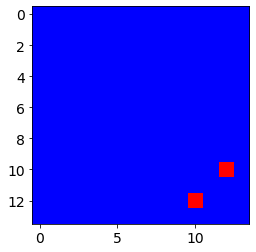

In [ ]:
print(f"aligned_kernel_parameters: {result['aligned_kernel_parameters']}")

from matplotlib import pyplot as plt
from pylab import cm
plt.rcParams['font.size'] = 14
plt.imshow(result['aligned_kernel_matrix']-np.identity(2*num_train), cmap=cm.get_cmap('bwr', 20))
plt.show()

##Use the results of the program to test an SVM on new data

In [ ]:
# from qiskit_runtime.qka import KernelMatrix
from qka import KernelMatrix
from sklearn.svm import SVC
from sklearn import metrics

# train the SVM with the aligned kernel matrix:

kernel_aligned = result['aligned_kernel_matrix']
model = SVC(C=C, kernel='precomputed')
model.fit(X=kernel_aligned, y=y_train)

# test the SVM on new data:

km = KernelMatrix(feature_map=fm, backend=backend, initial_layout=initial_layout)

In [ ]:
print(result['aligned_kernel_parameters'])

(18,)


In [ ]:
kernel_test = km.construct_kernel_matrix(x1_vec=x_test, x2_vec=x_train, parameters=result['aligned_kernel_parameters'])
labels_test = model.predict(X=kernel_test)
accuracy_test = metrics.balanced_accuracy_score(y_true=y_test, y_pred=labels_test)
print(f"accuracy test: {accuracy_test}")

accuracy test: 0.5


In [ ]:
print(kernel_test)

[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.00012207 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.00012207 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.      

##  Creating "Quantum Class"

In [ ]:
torch.device('cuda')

device(type='cuda')

In [ ]:
## Set code to run on device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
## Define data augmentation and transforms, resizing to 7 x 7 and converting RGB to Grayscale
chosen_transforms = {'train': transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.RandomResizedCrop(size=7),
        transforms.RandomRotation(degrees=10),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ColorJitter(brightness=0.15, contrast=0.15),
        transforms.ToTensor(),
        transforms.Normalize(mean_nums, std_nums)
]), 'val': transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize(7),
        transforms.CenterCrop(7),
        transforms.ToTensor(),
        transforms.Normalize(mean_nums, std_nums)
]),
}

In [ ]:
## Create the data loader
def load_dataset(format, batch_size):
    data_path = os.path.join(cwd, format)
    dataset = datasets.ImageFolder(
        root=data_path,
        transform= chosen_transforms[format]
    )
    data_loader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=2,
        shuffle=True
    )
    return data_loader, len(dataset), dataset.classes

In [ ]:
train_batch_size = 1
test_batch_size = 1
train_loader, train_sizes, class_names = load_dataset('train',train_batch_size)
test_loader, test_sizes, _ = load_dataset('val', test_batch_size)
idx_to_class = {0:'Negative', 1:'Positive'}
print("Train Data Set size is: ", train_sizes)
print("Class Names are: ", class_names)
inputs, classes = next(iter(train_loader))
print(inputs.shape, classes.shape)

Train Data Set size is:  25570
Class Names are:  ['Negative', 'Positive']
torch.Size([1, 1, 7, 7]) torch.Size([1])


In [ ]:
class QuantumCircuit:
    """ 
    This class provides a simple interface for interaction 
    with the quantum circuit 
    """
    
    def __init__(self, n_qubits, backend, shots):
        # --- Circuit definition ---
        self._circuit = qiskit.QuantumCircuit(n_qubits)
        
        all_qubits = [i for i in range(n_qubits)]
        self.theta = qiskit.circuit.Parameter('theta')
        
        self._circuit.h(all_qubits)
        self._circuit.barrier()
        self._circuit.ry(self.theta, all_qubits)
        
        self._circuit.measure_all()
        # ---------------------------

        self.backend = backend
        self.shots = shots
    
    def run(self, thetas):
        t_qc = transpile(self._circuit,
                         self.backend)
        qobj = assemble(t_qc,
                        shots=self.shots,
                        parameter_binds = [{self.theta: theta} for theta in thetas])
        job = self.backend.run(qobj)
        result = job.result().get_counts()
        
        counts = np.array(list(result.values()))
        states = np.array(list(result.keys())).astype(float)
        
        # Compute probabilities for each state
        probabilities = counts / self.shots
        # Get state expectation
        expectation = np.sum(states * probabilities)
        
        return np.array([expectation])

In [ ]:
simulator = qiskit.Aer.get_backend('aer_simulator')
# simulator = backend

circuit = QuantumCircuit(1, simulator, 100)
print(circuit.shape)
print('Expected value for rotation pi {}'.format(circuit.run([np.pi])[0]))
circuit._circuit.draw()

In [ ]:
class HybridFunction(Function):
    """ Hybrid quantum - classical function definition """
    
    @staticmethod
    def forward(ctx, input, quantum_circuit, shift):
        """ Forward pass computation """
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit

        expectation_z = ctx.quantum_circuit.run(input[0].tolist())
        result = torch.tensor([expectation_z])
        ctx.save_for_backward(input, result)

        return result
        
    @staticmethod
    def backward(ctx, grad_output):
        """ Backward pass computation """
        input, expectation_z = ctx.saved_tensors
        input_list = np.array(input.tolist())
        
        shift_right = input_list + np.ones(input_list.shape) * ctx.shift
        shift_left = input_list - np.ones(input_list.shape) * ctx.shift
        
        gradients = []
        for i in range(len(input_list)):
            expectation_right = ctx.quantum_circuit.run(shift_right[i])
            expectation_left  = ctx.quantum_circuit.run(shift_left[i])
            
            gradient = torch.tensor([expectation_right]) - torch.tensor([expectation_left])
            gradients.append(gradient)
        gradients = np.array([gradients]).T
        return torch.tensor([gradients]).float() * grad_output.float(), None, None

class Hybrid(nn.Module):
    """ Hybrid quantum - classical layer definition """
    
    def __init__(self, backend, shots, shift):
        super(Hybrid, self).__init__()
        self.quantum_circuit = QuantumCircuit(1, backend, shots)
        self.shift = shift
        
    def forward(self, input):
        return HybridFunction.apply(input, self.quantum_circuit, self.shift)

In [ ]:
weights = torch.tensor([result['aligned_kernel_parameters']])
print (weights.shape)
weights = torch.reshape(weights,(9,2))
weights = torch.unsqueeze(torch.unsqueeze(weights,0),3)
print(weights.shape)

torch.Size([1, 18])
torch.Size([1, 9, 2, 1])


In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 9, kernel_size=3)
        self.conv2 = nn.Conv2d(12, 16, kernel_size=3)
        self.conv3 = nn.Conv2d(1, 9, 2, 1)
        weights = torch.tensor([result['aligned_kernel_parameters']])
        weights = torch.reshape(weights,(9,2))
        weights = torch.unsqueeze(torch.unsqueeze(weights,0),3)
        self.conv3.weight.data = self.conv3.weight.data + weights.float()
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(256, 64)
        self.fc2 = nn.Linear(9, 1)
        self.hybrid = Hybrid(qiskit.Aer.get_backend('aer_simulator'),100, np.pi / 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        # x = F.relu(self.conv2(x))
        x = self.conv3(x.float())
        # x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(1, -1)
        # x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.hybrid(x)
        return torch.cat((x, 1 - x), -1)


In [ ]:
## Set code to run on device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


##Creating a "Quantum-Classical Class" with PyTorch

In [ ]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()

epochs = 20
loss_list = []
print("Training:")
model.train()
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        total_loss.append(loss.item())
    loss_list.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(
        100. * (epoch + 1) / epochs, loss_list[-1]))

Training:


<ipython-input-561-625640256c98>:32: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  gradients = np.array([gradients]).T


Training [50%]	Loss: -0.6706
Training [100%]	Loss: -0.7009


Text(0, 0.5, 'Neg Log Likelihood Loss')

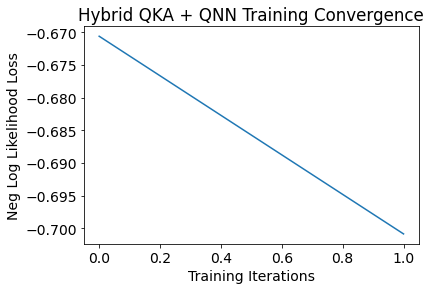

In [ ]:
plt.plot(loss_list)
plt.title('Hybrid QKA + QNN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Neg Log Likelihood Loss')

##Creating the Hybrid Neural Network

In [ ]:
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

Performance on test data:
	Loss: -0.7077
	Accuracy: 70.3%
